# KNN Classification-based Prediction of Heart Disease Diagnoses

## Introduction
Heart disease is a significant global health concern; it is the *leading cause of death globally*. To address this issue effectively, it is vital to develop accurate diagnostic tools. Fortunately, there are many patient attributes that could serve as indicators or possible warning signs for heart disease, which could accelerate the process of diagnosis and treatment. In this project, we will employ classification techniques to predict the diagnosis of heart disease based on a few of these attributes.

**Research question:** Will a patient be diagnosed with heart disease, given their age, resting blood pressure, cholesterol levels, and maximum heart rate achieved, while considering sex differences?

The dataset we will use to answer this question is the UCI Heart Disease dataset, which comprises multivariate numerical and categorical data on 14 patient attributes. These include age, sex, chest pain type, etc. along with the patient's diagnosis. For this project, we will focus on a subset of attributes: 
- age
- resting blood pressure
- serum cholesterol
- maximum heart rate achieved

to predict the diagnosis of heart disease. We will filter the dataset to include only records from the Cleveland location to ensure consistency and relevance. By the end of this project, we aim to develop accurate predictive models for diagnosing heart disease based on patient attributes.

## Exploratory data analysis

In [1]:
# Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 5)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
heart <- read_csv("https://raw.githubusercontent.com/chiefpat450119/dsci-project/main/data/heart_disease_uci.csv")

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We then filter the data to look at **only one location (Cleveland)** to reduce the effect of possible confounding variables introduced by the local environment.

In [3]:
cleveland_heart <- heart |>
filter(dataset == "Cleveland")

In order to use classification, we need to change the predicted variable (num) to a *factor* with more understandable levels. From the information presented in the dataset, num = 0 represents absence of disease, while num = 1, 2, 3, 4 represent stages of heart disease. The refactoring will be done based on the following interpretation:
- 0 = "absent"
- 1 = "mild"
- 2 = "moderate"
- 3 = "severe"
- 4 = "critical"

In [4]:
heart_refactored <- cleveland_heart |>
mutate(disease = as_factor(num)) |>
mutate(disease = fct_recode(disease, "absent" = "0", "mild" = "1", "moderate" = "2", "severe" = "3", "critical" = "4"))
heart_refactored

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<fct>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0,absent
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2,moderate
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1,mild
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
303,38,Male,Cleveland,non-anginal,138,175,FALSE,normal,173,FALSE,0,upsloping,NA,normal,0,absent
304,28,Male,Cleveland,atypical angina,130,132,FALSE,lv hypertrophy,185,FALSE,0,NA,NA,NA,0,absent


<p style="text-align:center;"><strong>TABLE 1- Transformed Cleveland Heart Disease Dataset: 'Disease' severity recoded into categorical levels for easier interpretation</strong></p>


The data is already in a tidy format. We now split the data into a training and a testing set, making sure there are equal ratios of each disease classification in both sets. Let's take a look at how many cases are in each disease class, and then break it down by sex.

In [5]:
set.seed(23)
heart_split <- initial_split(heart_refactored, prop = 0.75, strata = disease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

In [6]:
heart_train_summary <- heart_train |>
group_by(disease) |>
summarize(count = n())
heart_train_summary

disease,count
<fct>,<int>
absent,124
mild,42
moderate,27
severe,25
critical,9


<p style="text-align:center;"><strong>TABLE 2- Heart Disease Severity Summary: Distribution of heart disease cases across severity levels in the training dataset</strong></p>


In [7]:
options(repr.matrix.max.rows = 10)
heart_train_split <- heart_train |>
group_by(disease, sex) |>
summarize(count = n())
heart_train_split

`summarise()` has grouped output by 'disease'. You can override using the
`.groups` argument.


disease,sex,count
<fct>,<chr>,<int>
absent,Female,53
absent,Male,71
mild,Female,5
mild,Male,37
moderate,Female,6
moderate,Male,21
severe,Female,7
severe,Male,18
critical,Female,2


<p style="text-align:center;"><strong>TABLE 3- Heart Disease Distribution by Severity and Gender: Summary of heart disease cases categorized by severity levels and gender from the training dataset </strong></p>


There is a difference in the distribution of cases between male and female patients. There is a **significantly greater proportion** of patients in the disease classes for male patients. This will need to be kept in mind for our analysis. 

Some disease classes have **very few observations,** especially for female patients, which creates a large **class imbalance**, where the class with no disease is far larger than the others. This will make it hard to train a useful classification model, since it might just end up predicting the most common class every time. We can correct this imbalance this by **combine all the disease classes into one**:

In [8]:
options(repr.matrix.max.rows = 5)
heart_train <- mutate(heart_train, disease = as_factor(case_when(disease == "absent" ~ "absent", TRUE ~ "present")))
heart_test <- mutate(heart_test, disease = as_factor(case_when(disease == "absent" ~ "absent", TRUE ~ "present")))
heart_train

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<fct>
4,37,Male,Cleveland,non-anginal,130,250,FALSE,normal,187,FALSE,3.5,downsloping,0,normal,0,absent
5,41,Female,Cleveland,atypical angina,130,204,FALSE,lv hypertrophy,172,FALSE,1.4,upsloping,0,normal,0,absent
6,56,Male,Cleveland,atypical angina,120,236,FALSE,normal,178,FALSE,0.8,upsloping,0,normal,0,absent
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
297,59,Male,Cleveland,asymptomatic,164,176,TRUE,lv hypertrophy,90,FALSE,1.0,flat,2,fixed defect,3,present
301,57,Male,Cleveland,asymptomatic,130,131,FALSE,normal,115,TRUE,1.2,flat,1,reversable defect,3,present


<p style="text-align:center;"><strong>TABLE 4- Modified Heart Disease Training Dataset: Updated dataset where the 'disease' column has been recategorized as 'absent' or 'present' for ease of interpretation</strong></p>


Let's see how many missing values there are for each predictor.

In [9]:
missing <- enframe(colSums(is.na(heart_train))) |>
pivot_wider(names_from = "name", values_from = "value")
missing

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,0,0,1,3,3,0,0


<p style="text-align:center;"><strong>TABLE 5- Missing Data Summary: Distribution of missing values across columns in the heart_train dataset</strong></p>


### Selected predictors
- Age
- Resting blood pressure (trestbps)
- Serum cholesterol (chol)
- Maximum heart rate achieved (thalch)

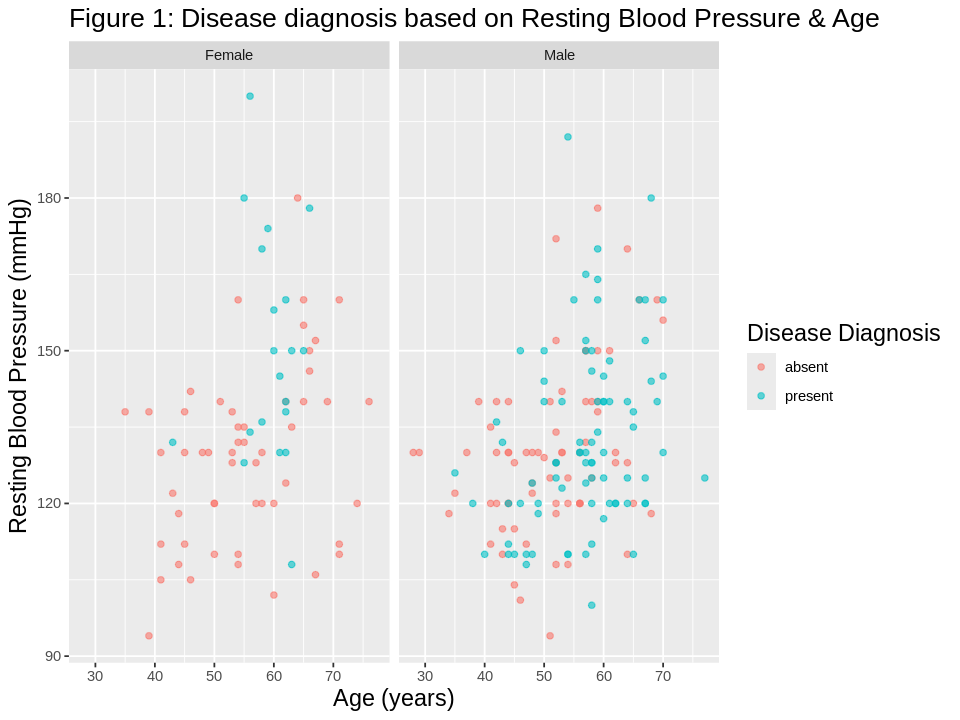

In [10]:
# Let's look at how two of predictor variables correlate with heart disease.
options(repr.plot.width = 8, repr.plot.height = 6)
heart_age_bp_plot <- heart_train |>
  ggplot(aes(x = age, y = trestbps, color = disease)) +
  geom_point(alpha = 0.6) + 
  labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", color = "Disease Diagnosis") +
  ggtitle("Figure 1: Disease diagnosis based on Resting Blood Pressure & Age") +
  theme(
    plot.title = element_text(size = 16),  # Adjust title size
    axis.title = element_text(size = 14),  # Adjust axis label size
    legend.title = element_text(size = 14) # Adjust legend title size
  ) +
  facet_grid(cols = (vars(sex)))

heart_age_bp_plot

Figure 1 depicts the relationship between Resting Blood Pressure in mmHg and Age in years for both males and females. It shows that there is little to no correlation between the two variables and that the relationship is nonlinear. The data points are closely clustered together and appear more like a cloud than a distinct line or curve, indicating that there is no strong relationship between the two variables. It is interesting to note that for females, higher age is more likely to have higher resting blood pressure, although this relationship is not as strong as expected. This trend is somewhat true for males as well, although it is not as pronounced. Additionally, it can be observed that there are fewer data points for females compared to males, which may suggest a smaller sample size for the female population. 

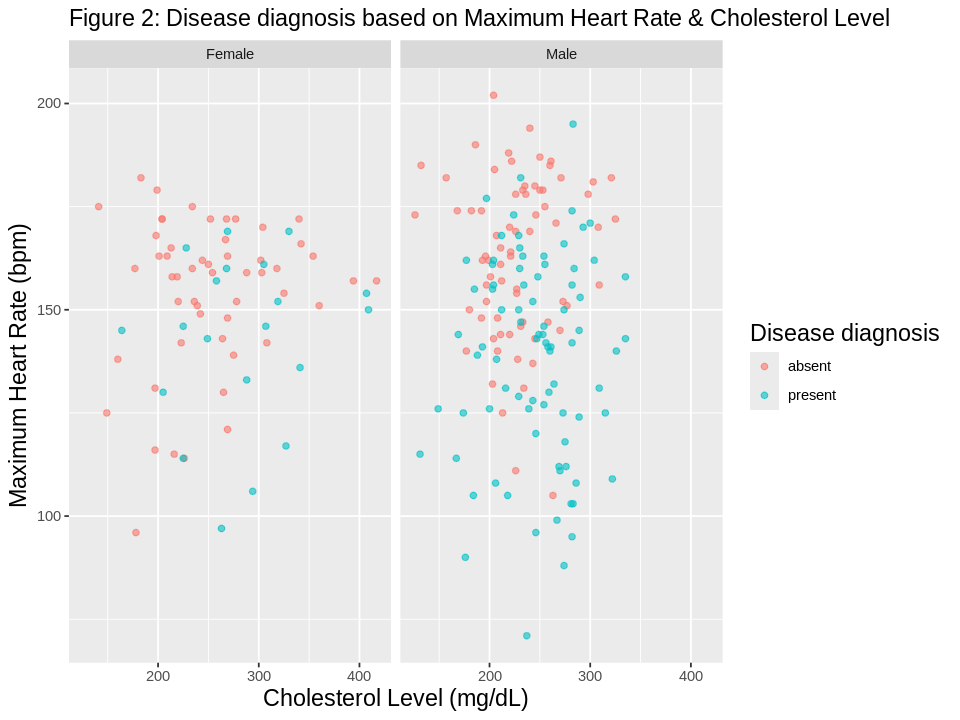

In [11]:
# Now the other two predictor variables
options(repr.plot.width = 8, repr.plot.height = 6)
heart_chol_hr_plot <- ggplot(heart_train, aes(x = chol, y = thalch, color = disease)) + 
  geom_point(alpha = 0.6) + 
  labs(x = "Cholesterol Level (mg/dL)",  # Including unit
       y = "Maximum Heart Rate (bpm)", 
       color = "Disease diagnosis") + 
  ggtitle("Figure 2: Disease diagnosis based on Maximum Heart Rate & Cholesterol Level") +
  theme(
    plot.title = element_text(size = 14),  # Adjust title size
    axis.title = element_text(size = 14),  # Adjust axis label size
    legend.title = element_text(size = 14) # Adjust legend title size
  ) +
  facet_grid(cols = (vars(sex)))
heart_chol_hr_plot

The second figure illustrates the correlation between Maximum Heart Rate in bpm and Cholesterol Level in mg/dl for both males and females. It is evident that the graph is nonlinear for both genders, indicating that there is no significant relationship between the two variables. As seen in Figure 1, Maximum Heart Rate does not exhibit a meaningful increase or decrease as Cholesterol Level increases, thereby suggesting that the variables have little to no relation. It can also be noted that the majority of men have their cholesterol levels between 200-250 mg/dl, whereas the data for females ranges more widely, between 200-300 mg/dl. Moreover, it is observed that men tend to have a higher maximum heart rate than females.

# Methods
To build a model for predicting the diagnosis of heart disease, we will follow the outlined approach.

In the data preprocessing phase, we will focus on filtering the dataset to include only observations from the Cleveland area, aiming to reduce potential confounding variables introduced by regional differences. We will then split the data into training and testing sets. The disease classes will be combined into one because some of the original classes had too few observations to use classification effectively (large class imbalance), seen in table 2 where critical condition only had 9 observations.
Then, we will select the following predictors: age, resting blood pressure, cholesterol, and maximum heart rate.
These were chosen because they are numerical variables, which are much more useful than the other categorical variables for KNN classification, and they also do not have any missing data (see table 5).

For model fitting and evaluation, we will split the training and testing sets both into male and female sets, due to the notable sex differences in diagnoses and predictor variables, seen in the discrepancies between male and female graphs in figure 1 and figure 2. Furthermore, both studies cited in this report as well as many other studies in journals all chose to differentiate sex data in the development and evaluation of predictive models. We will be training a K-nearest neighbours classification model, so we will first need to use a recipe to scale and center the data. The model will be trained on the training set, using cross-validation to choose the optimal value of K, then evaluated on the testing set using accuracy, precision, and recall. Recall will be prioritized because false negative predictions (classifying disease "present" as "absent") are more costly. This evaluation process will be conducted separately for male and female categories to account for sex-specific variations.

We will also visualize the accuracy, precision, and recall for both the male and female datasets when the model is evaluated on the **test data** using a combined bar chart, and also compare it to the cross-validation accuracy from the training set. Lastly, we will also display the confusion matrix (true positives, false positives, etc.) for each sex.

## Expected outcomes and significance
Based on the outlined methods, we expect to find predictive models capable of accurately diagnosing heart disease based on patient attributes like age, blood pressure, cholesterol, and maximum heart rate achieved. We also expect there to be  differences in the model predictions and results for male and female patients due to the differing distributions seen in figures 1 and 2. Such findings could lead to improved early detection and treatment, potentially reducing the burden of heart disease globally. Future questions may explore the effectiveness of these models across different demographics, as well as their integration into clinical practice for better patient outcomes.

## Data Processing and Analysis
### Preparing Data for Analysis
We already have training and testing datasets from just the Cleveland location with the disease classes combined. Let's continue by selecting only the required columns and dividing both sets into male and female.

In [12]:
# Select only columns we are using
heart_train <- select(heart_train, age, sex, trestbps, chol, thalch, disease)
heart_test <- select(heart_test, age, sex, trestbps, chol, thalch, disease)

In [13]:
#Filtering training dataset for Male
m_train <- filter(heart_train, sex == "Male")
m_train

age,sex,trestbps,chol,thalch,disease
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
37,Male,130,250,187,absent
56,Male,120,236,178,absent
57,Male,140,192,148,absent
⋮,⋮,⋮,⋮,⋮,⋮
59,Male,164,176,90,present
57,Male,130,131,115,present


<p style="text-align:center;"><strong>TABLE 6- Training set
    for Male</strong></p>


In [14]:
#Filtering training dataset for Female
f_train <- filter(heart_train, sex == "Female")
f_train

age,sex,trestbps,chol,thalch,disease
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
41,Female,130,204,172,absent
57,Female,120,354,163,absent
48,Female,130,275,139,absent
⋮,⋮,⋮,⋮,⋮,⋮
58,Female,136,319,152,present
55,Female,128,205,130,present


<p style="text-align:center;"><strong>TABLE 7- Training set for Female</strong></p>


In [15]:
#Filtering testing dataset for Male
m_test <- filter(heart_test, sex == "Male")
m_test

age,sex,trestbps,chol,thalch,disease
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
63,Male,145,233,150,absent
63,Male,130,254,147,present
44,Male,120,263,173,absent
⋮,⋮,⋮,⋮,⋮,⋮
63,Male,140,187,144,present
38,Male,138,175,173,absent


<p style="text-align:center;"><strong>TABLE 8- Testing set for Male</strong></p>


In [16]:
#Filtering testing dataset for Female
f_test <- filter(heart_test, sex == "Female")
f_test

age,sex,trestbps,chol,thalch,disease
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
56,Female,140,294,153,absent
58,Female,150,283,162,absent
51,Female,130,305,142,present
⋮,⋮,⋮,⋮,⋮,⋮
57,Female,140,241,123,present
57,Female,130,236,174,present


<p style="text-align:center;"><strong>TABLE 9- Testing set for Female</strong></p>


### Using Cross-Validation to Tune the KNN Model

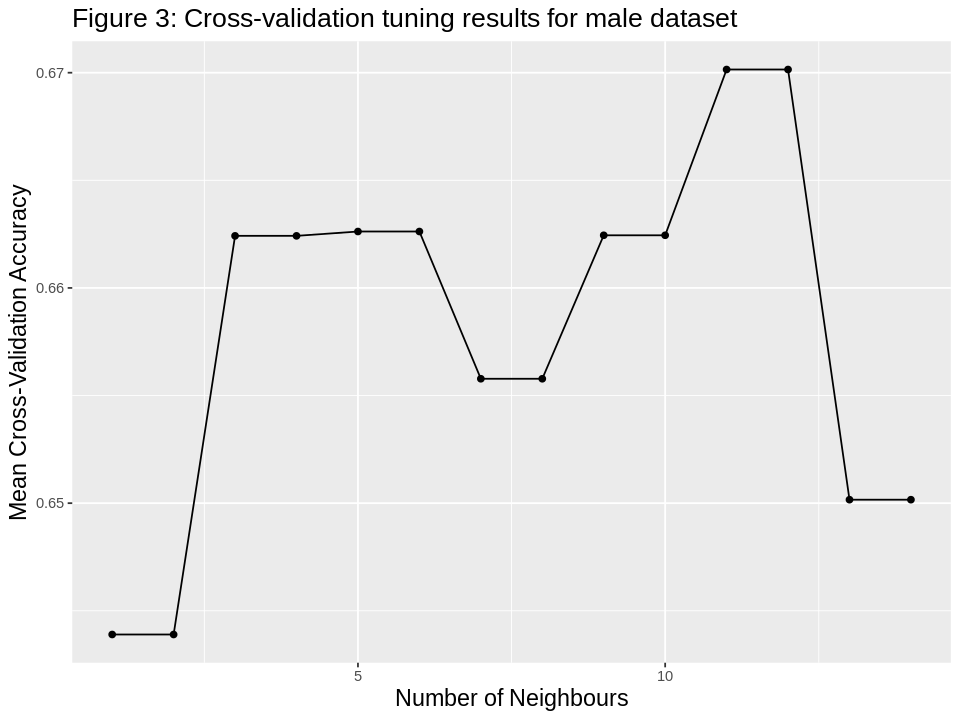

In [17]:
set.seed(11)
# Perform cross-validation to choose K for male
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")
m_recipe <- recipe(disease ~ age + trestbps + chol + thalch, data = m_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

# Create vfold (5 folds) and gridvals tibble 
m_vfold <- vfold_cv(m_train, 5, strata = disease)
gridvals <- tibble(neighbors = seq(from = 1, to = 14, by = 1))

# Run tuning workflow and collect metrics
m_fit_tune <- workflow() |>
add_recipe(m_recipe) |>
add_model(knn_spec_tune) |>
tune_grid(resamples = m_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "accuracy")

m_tune_plot <- ggplot(m_fit_tune, aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() + 
labs(x = "Number of Neighbours", y = "Mean Cross-Validation Accuracy", title = "Figure 3: Cross-validation tuning results for male dataset") +
theme(
    plot.title = element_text(size = 16),  # Adjust title size
    axis.title = element_text(size = 14),  # Adjust axis label size
  ) 
m_tune_plot

For the male dataset, we will select $k = 5$ since it has close to the highest accuracy on the cross-validation, and also because changing to a nearby value (4 or 6) does not change the accuracy too significantly (the difference is less than 0.005), so that the choice will be reliable in the presence of uncertainty.  
We avoided choosing $k = 11$ or $k = 12$ even though they have very slightly higher accuracy, since choosing these may pose too high a risk to cause underfitting, so that the model would not generalise well to the test data or a new dataset.

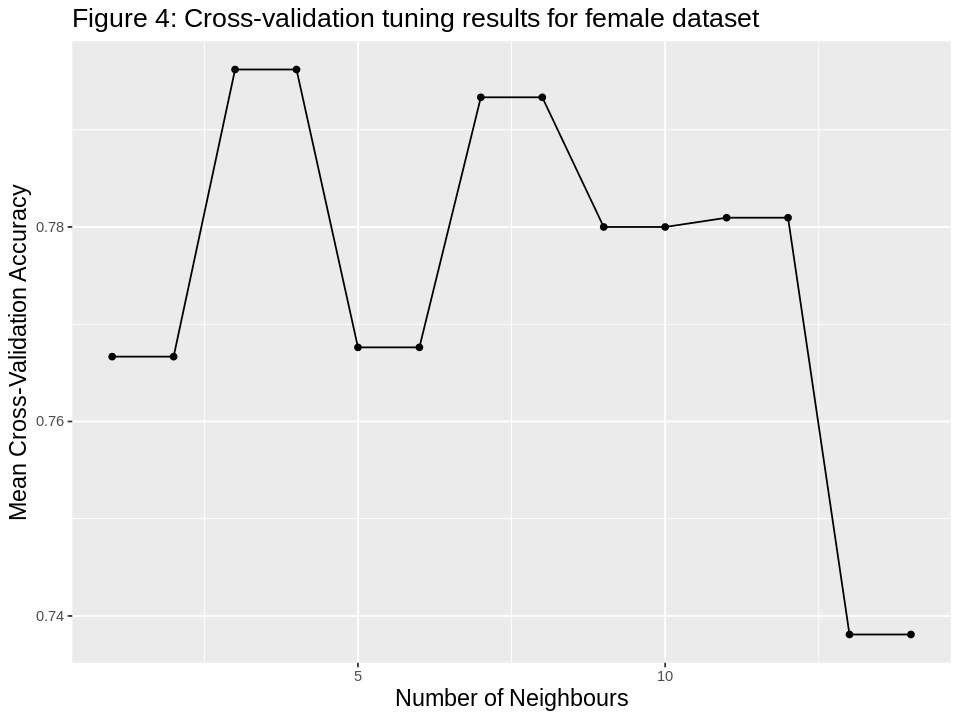

In [18]:
set.seed(11)
# Perform cross-validation to choose K for female
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
f_recipe <- recipe(disease ~ age + trestbps + chol + thalch, data = f_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Create vfold (5 folds) and gridvals tibble 
f_vfold <- vfold_cv(f_train, 5, strata = disease)
gridvals <- tibble(neighbors = seq(from = 1, to = 14, by = 1))

# Run tuning workflow and collect metrics
f_fit_tune <- workflow() |>
  add_recipe(f_recipe) |>
  add_model(knn_spec_tune) |>
  tune_grid(resamples = f_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

f_tune_plot <- ggplot(f_fit_tune, aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() + 
labs(x = "Number of Neighbours", y = "Mean Cross-Validation Accuracy", title = "Figure 4: Cross-validation tuning results for female dataset") +
theme(
    plot.title = element_text(size = 16),  # Adjust title size
    axis.title = element_text(size = 14),  # Adjust axis label size
  ) 
f_tune_plot

For the female dataset, we will select $k = 3$ since it has the highest accuracy on the cross-validation, and also because changing to a nearby value (8 or 10) does not change the accuracy too significantly (no more than a 0.02 difference in accuracy), so that the choice will be reliable in the presence of uncertainty. This value is also not too low or high so we can avoid potential over or underfitting.

In [19]:
# Get the cross-validation accuracy for the male set (k = 5)
m_cv_accuracy <- m_fit_tune |> 
filter(neighbors == 5) |>
mutate(sex = "Male")
m_cv_accuracy |> pull(mean)

[1] 0.662621

In [20]:
# Get the cross-validation accuracy for the female set (k = 3)
f_cv_accuracy <- f_fit_tune |> 
filter(neighbors == 3) |>
mutate(sex = "Female")
f_cv_accuracy |> pull(mean)

[1] 0.7961905

We can see that the best accuracy on cross-validation for the male set was around 66%, and the best accuracy for the female set was around 80%. We will compare this to the accuracy on the test set later to evaluate its predictions.

### Testing and Evaluation

Now let's predict the labels on the **testing** set and evaluate the model based on the results.

In [21]:
# Train models using the optimal values of k
# Male (k = 5)
m_spec_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
set_engine("kknn") |>
set_mode("classification")

m_fit_final <- workflow() |>
add_recipe(m_recipe) |>
add_model(m_spec_optimal) |>
fit(m_train)

# Female (k = 3)
f_spec_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
set_engine("kknn") |>
set_mode("classification")

f_fit_final <- workflow() |>
add_recipe(f_recipe) |>
add_model(f_spec_optimal) |>
fit(f_train)

In [22]:
# Predict on the testing set using the optimal value of K for male (K=5)
m_test_predictions <- predict(m_fit_final, m_test) |>
  bind_cols(m_test)
m_test_predictions

.pred_class,age,sex,trestbps,chol,thalch,disease
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
absent,63,Male,145,233,150,absent
present,63,Male,130,254,147,present
absent,44,Male,120,263,173,absent
⋮,⋮,⋮,⋮,⋮,⋮,⋮
present,63,Male,140,187,144,present
absent,38,Male,138,175,173,absent


<p style="text-align:center;"><strong>TABLE 10- Predictions on Testing Set with Optimal $k=5$ for Males </strong></p>


In [23]:
# Predict on the testing set using the optimal value of K for female (K=3)
f_test_predictions <- predict(f_fit_final, f_test) |>
  bind_cols(f_test)
f_test_predictions

.pred_class,age,sex,trestbps,chol,thalch,disease
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
absent,56,Female,140,294,153,absent
present,58,Female,150,283,162,absent
absent,51,Female,130,305,142,present
⋮,⋮,⋮,⋮,⋮,⋮,⋮
absent,57,Female,140,241,123,present
absent,57,Female,130,236,174,present


<p style="text-align:center;"><strong>TABLE 11- Predictions on Testing Set with Optimal $k=3$ for Female </strong></p>


In [24]:
# Calculate accuracy for male test data
m_test_accuracy <- m_test_predictions |>
    metrics(truth = disease, estimate = .pred_class)|>
    filter(.metric == "accuracy")
m_test_accuracy |> pull(.estimate)

[1] 0.6603774

In [25]:
# Calculate accuracy for female test data
f_test_accuracy <- f_test_predictions |>
    metrics(truth = disease, estimate = .pred_class)|>
    filter(.metric == "accuracy")
f_test_accuracy |> pull(.estimate)

[1] 0.7083333

In [26]:
#Recall for Male Test Predictions (set "present" as the positive class)
m_recall <- m_test_predictions |>
   recall(truth = disease, estimate = .pred_class, event_level = "second")
m_recall |> pull(.estimate)

[1] 0.6451613

In [27]:
#Precision for Male Test Predictions (set "present" as the positive class)
m_precision <- m_test_predictions |>
   precision(truth = disease, estimate = .pred_class, event_level = "second")
m_precision |> pull(.estimate)

[1] 0.7407407

In [28]:
#Recall for Female Test Predictions (set "present" as the positive class)
f_recall <- f_test_predictions |>
   recall(truth = disease, estimate = .pred_class, event_level = "second")
f_recall |> pull(.estimate)

[1] 0.2

In [29]:
#Precision for Female Test Predictions (set "present" as the positive class)
f_precision <- f_test_predictions |>
   precision(truth = disease, estimate = .pred_class, event_level = "second")
f_precision |> pull(.estimate)

[1] 0.25

In [30]:
#Confusion Matrix for Male Test Predictions
confusion_m <- m_test_predictions |>
   conf_mat(truth = disease, estimate = .pred_class)
confusion_m

          Truth
Prediction absent present
   absent      15      11
   present      7      20

<p style="text-align:center;"><strong>TABLE 12- Confusion Matrix for Male </strong></p>


In [31]:
#Confusion Matrix for Female Test Predictions
confusion_f <- f_test_predictions |>
   conf_mat(truth = disease, estimate = .pred_class)
confusion_f

          Truth
Prediction absent present
   absent      16       4
   present      3       1

<p style="text-align:center;"><strong>TABLE 13- Confusion Matrix for Female </strong></p>


### Visualising results

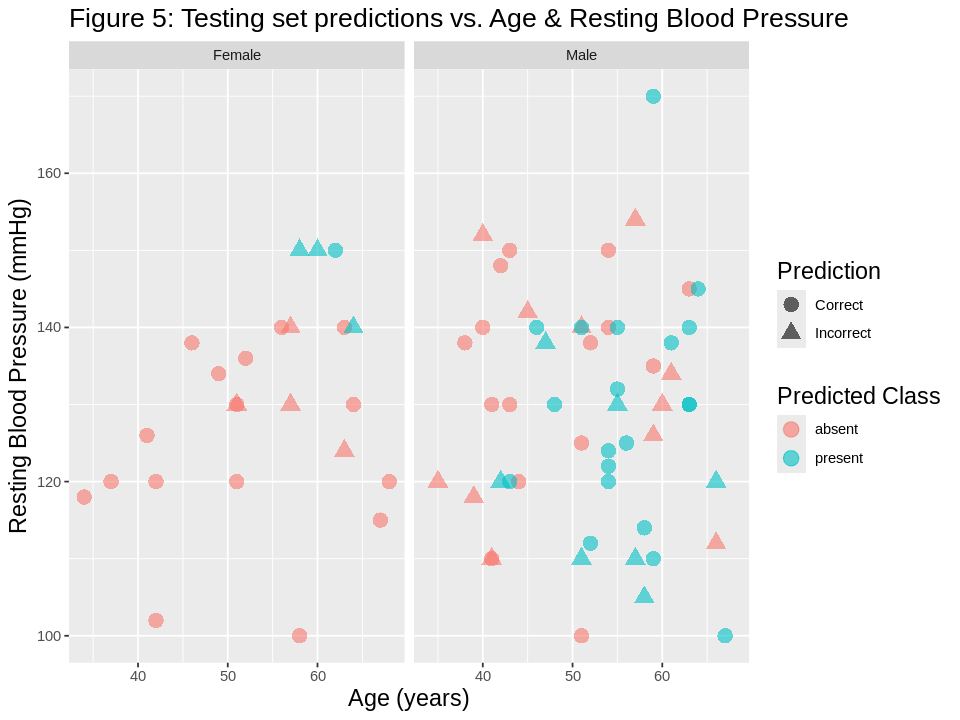

In [32]:
options(repr.plot.width = 8, repr.plot.height = 6)
# Append column to predictions indicating whether prediction is correct
all_predictions <- bind_rows(m_test_predictions, f_test_predictions) |>
mutate(matching = case_when(disease == .pred_class ~ "Correct", TRUE ~ "Incorrect")) 

age_bp_predictions_plot <- all_predictions |>
ggplot(aes(x = age, y = trestbps, color = .pred_class, shape = matching)) +
  geom_point(size = 4, alpha = 0.6) + 
  labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", color = "Predicted Class", shape = "Prediction") +
ggtitle("Figure 5: Testing set predictions vs. Age & Resting Blood Pressure") +  
  theme(
    plot.title = element_text(size = 16),  # Adjust title size
    axis.title = element_text(size = 14),  # Adjust axis label size
    legend.title = element_text(size = 14) # Adjust legend title size
  ) +
  facet_grid(cols = (vars(sex)))

age_bp_predictions_plot

Figure 5 compares the predictions made on the testing set with respect to age and resting blood pressure, while also taking into account sex differences. When comparing Figure 5 with Figure 1 (representing the training set), the overall pattern of the predictions seem to match the distribution of the training data for males, but for females there is a much smaller region where "present" was predicted.

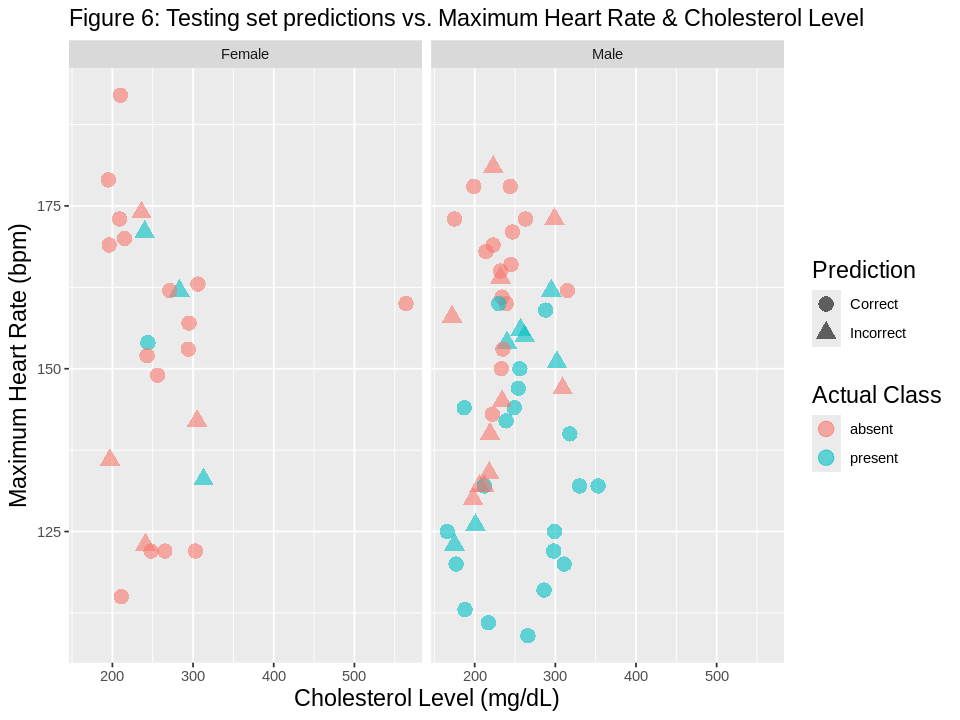

In [33]:
options(repr.plot.width = 8, repr.plot.height = 6)
chol_hr_predictions_plot <- all_predictions |>
ggplot(aes(x = chol, y = thalch, color = .pred_class, shape = matching)) +
    geom_point(size = 4, alpha = 0.6) + 
    labs(x = "Cholesterol Level (mg/dL)",  # Including unit
       y = "Maximum Heart Rate (bpm)", 
       color = "Actual Class", shape = "Prediction") + 
  ggtitle("Figure 6: Testing set predictions vs. Maximum Heart Rate & Cholesterol Level") +  
theme(
    plot.title = element_text(size = 14),  # Adjust title size
    axis.title = element_text(size = 14),  # Adjust axis label size
    legend.title = element_text(size = 14) # Adjust legend title size
  ) +
  facet_grid(cols = (vars(sex)))
chol_hr_predictions_plot

Figure 6 depicts the testing set predictions against maximum heart rate and cholesterol level, showing similar trends to Figure 5: the testing prediction patterns match the training data (Figure 2) closely on the male dataset, but for the female dataset the model had a harder time finding a defined region to predict "present".

Figures 5 and 6 show that the KNN model was able to find patterns in the predictors to classify "present" and "absent" for males, since the prediction patterns are similar to the training data distribution. However, this was not true for females: the predictions lined up less well with the training data distribution. This could be due to the class imbalance in the training data (see figure 1) causing the KNN model to predict "absent" more often in the female data set since it makes up the majority of points.

Becuase of this, there is a noticeable difference in prediction accuracy between males and females, with the predictions for females being more accurate overall, but only for negative predictions, which are less important in the context of this study. For females, the model made a lot of false negatives (costly) compared to the number of total positive predictions, due to the model not being able to correctly predict the presence of disease from the given training data and predictor variables, so the model's recall was very poor.

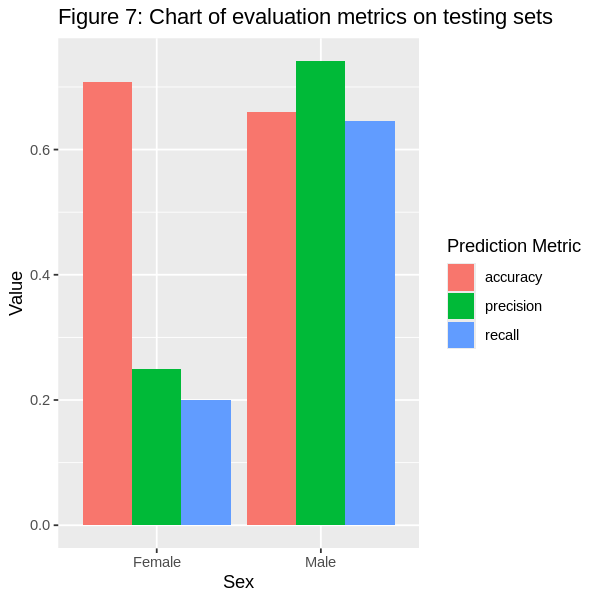

In [34]:
# Visualise evaluation metrics
options(repr.matrix.max.rows = 6)
options(repr.plot.height = 5)
options(repr.plot.width = 5)
m_merged_metrics <- bind_rows(m_test_accuracy, m_precision, m_recall) |>
mutate(sex = "Male")
f_merged_metrics <- bind_rows(f_test_accuracy, f_precision, f_recall) |>
mutate(sex = "Female")

all_metrics <- bind_rows(m_merged_metrics, f_merged_metrics) |>
group_by(sex)

all_metrics_plot <- ggplot(all_metrics, aes(x = sex, y = .estimate, fill = .metric)) +
geom_bar(stat = "identity", position = "dodge") + 
labs(fill = "Prediction Metric", x = "Sex", y = "Value", title = "Figure 7: Chart of evaluation metrics on testing sets")
all_metrics_plot

We can see that the KNN classification model was somewhat successful in terms of accuracy for the male dataset, with an accuracy of around 65% according to figure 7. Precision is also moderately high at around 70%. However, considering the context of this data analysis, recall should be the most important metric to consider, since it is the ratio of correct positive predictions to total actual positives. This means that it is impacted by false negatives, which are the most costly errors in the context of predicting disease, since it would be very bad to predict a diseased case as healthy. For the male dataset, the recall is rather mediocre at around 65%, which would mean this prediction model is not suitable for diagnosing heart disease in new patients.

As for the female dataset, the accuracy is actually higher than the male dataset at around 70%, however, looking at the confusion matrix in table 13 along with figures 5 and 6, this appears to be because the model simply guessed "absent" the majority of the time, and because the female dataset is imbalanced towards "absent" disease (see figure 1 and 2), which created an illusion of good performance. However, by looking at precision and recall which are both below 25% for the female data set which is very poor in terms of being able to accurately diagnose heart disease in female patients with this training data.

Let's compare these metrics to the earlier model accuracies from the training set:

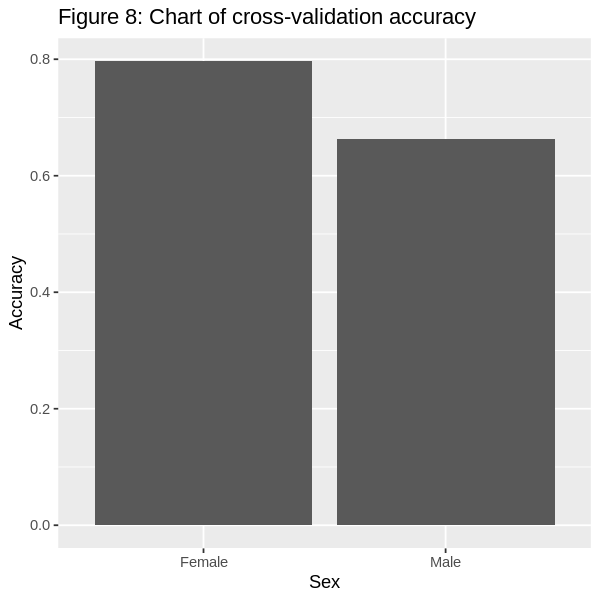

In [35]:
cv_accuracy_plot <- bind_rows(m_cv_accuracy, f_cv_accuracy) |>
ggplot(aes(x = sex, y = mean)) + 
geom_bar(stat = "identity") + 
labs(x = "Sex", y = "Accuracy", title = "Figure 8: Chart of cross-validation accuracy")
cv_accuracy_plot

We can see from figure 8 that the cross-validation accuracy was 80% for female and around 65% for male. The accuracy on the male dataset is very similar, but the accuracy for the female data set was substantially higher on the training than the testing set (80% vs 70%). This might indicate that the model was either under- or over-fitting on the testing data. Given the low $k$ value of 3, it is possible that this could be due to overfitting. This could be assessed in future analysis to improve the predictive power of the model.

## Discussion
**SUMMARY:**

This study aimed to develop predictive models for diagnosing heart disease based on patient attributes like age, blood pressure, cholesterol, and maximum heart rate, focusing on the UCI Heart Disease dataset's Cleveland subset. Notable differences were observed between male and female patients in both diagnoses and predictor variables. To address class imbalance, disease classes were combined. K-nearest neighbors (KNN) classification models were trained and evaluated separately for male and female datasets, prioritizing recall due to the cost of false negatives.

The results indicate **moderately good performance** in diagnosing heart disease using the aformentioned predictors among male patients but **not among female patients**. *To some extent*, we can predict whether a male patient will be diagnosed with heart disease, but we cannot do the same for female patients.

This suggests that the model is more adept at correctly identifying heart disease cases in male patients compared to female patients. This may mean that these predictors or this model are not suitable for female patients or there may be other factors causing the poor performance (discussed below). Further research may explore improving model performance for female patients, (possibly by experimenting with different predictors, using a larger sample size or different classification algorithm), and investigating demographic variations in model effectiveness for broader clinical applicability.

**EXPECTATIONS vs. FINDINGS:**

The results for male patients align somewhat with expectations, as the model was able to predict with 65% accuracy on the training data, with similar values for precision and recall (See Figure 7). There was a significantly greater proportion of male patients in the disease classes (see table 3), suggesting that the relatively good performance of the model for males could be attributed to there being sufficient training data with balanced classes.

However, the findings for female patients are unexpected, as the selected variables did not yield the desired level of performance in predicting heart disease (20% recall, Figure 7), despite the training set seeming to show greater separation in the two classes for females (figure 1 and 2). The unexpected findings for female patients can be attributed to several factors, such as class imbalance (see figures 1 and 2) and a smaller sample size (see tables 6-9), which may have led to a lack of sufficient training data for the model to learn and predict effectively. The small size of the female testing data set (especially the positive class) may have also caused the low precision/recall observed, due to the possible large impacts of outliers in the test set (see figures 5 and 6). Comparing figures 7 and 8, it is also *possible* that the model was overfitting for females, meaning it was influenced too much by the training data set.

Although it was considered to create a color diagram to check for under/overfitting, we were limited by the available computational resources. Nonetheless, the model's performance was close to expectations for males, suggesting that it could be a useful assistive tool to diagnose heart disease in male patients, despite being a rudimentary model with a smaller dataset. Previous literature found model precisions of 0.8671 for males and 0.8991 for females in studies of similar topics. (Yang et. al, 2023) so we expected our model to produce similar results. However, the results show that although our model produced somewhat similar precision on the male dataset (~75%), the model greatly underperformed compared to literature models on the female dataset. This can be explained by the aforementioned reasons, especially the small sample size used for female patients in our model as compared to literature.

**IMPACT OF FINDINGS:**

Such findings could have significant implications for healthcare practices and policies. For instance, they could underscore the importance of considering sex-specific differences in the development and evaluation of predictive models for heart disease diagnosis. (Ahmad, 2023). Additionally, it might prompt further investigation into the factors contributing to the disparity in model performance between male and female patients.

**FUTURE QUESTIONS:**

These findings could lead to several future research questions, such as:
1. What are the underlying reasons for the disparity in model performance between male and female patients?
2. Are there additional patient attributes or variables that should be considered to improve the accuracy of heart disease diagnosis models for female patients?
3. Would the model be able to better predict the presence of disease in female patients given a larger training dataset?

Overall, these findings highlight the importance of ongoing research and development efforts to address sex-specific differences in heart disease diagnosis and treatment, ultimately leading to improved healthcare outcomes for all patients.

## References

Yang, H., Luo, Y.-M., Ma, C.-Y., Zhang, T.-Y., Zhou, T., Ren, X.-L., … Lin, H. (2023). A gender specific risk assessment of   coronary heart disease based on Physical Examination Data. *Npj Digital Medicine, 6*(1). doi:10.1038/s41746-023-00887-8 

Ahmad AA, Polat H. (2023). Prediction of Heart Disease Based on Machine Learning Using Jellyfish Optimization Algorithm. *Diagnostics*, 13(14). doi: 10.3390/diagnostics13142392.

Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. (1988). Heart Disease. *UCI Machine Learning Repository*. doi: 10.24432/C52P4X